# Analyze A/B Test Results 

The subjects covered in notebook are separated into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project,I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.




**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** I use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [6]:
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]['user_id'].count()

1965

In [8]:
df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')]['user_id'].count()

1928

In [9]:
1965+1928

3893

In [10]:
df['landing_page'].unique()

array(['old_page', 'new_page'], dtype=object)

**f.** Do any of the rows have missing values?

In [11]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



In [78]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].index)
df2 = df2.drop(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].index)

In [79]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
I use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [80]:
df2['user_id'].nunique()

290584

In [81]:
df2.shape[0]

290585

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [82]:
df2.loc[df2['user_id'].duplicated(), ['user_id']]

,user_id
2893,773192


**c.** Display the rows for the duplicate **user_id**? 

In [83]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [84]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [85]:
# Remove one of the rows with a duplicate user_id.. 
df2 = df2.drop_duplicates(subset=['user_id'], keep="first")
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>



In [86]:
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [87]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

In [88]:
contr_mean = df2[df2['group'] == 'control']['converted'].mean()

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [89]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

In [90]:
treat_mean = df2[df2['group'] == 'treatment']['converted'].mean()

In [91]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treat_mean - contr_mean

**d.** What is the probability that an individual received the new page?

In [92]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

In [93]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


>**Since the the two groups are approximately equal to each other (Cell d), we can tell that the treatment group is leading to less cenversions than the control group(Cells b and c) .**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, I could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider we need to make the decision just based on all the data provided.  

> Recall that I just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be my null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

I can state my hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

$$H_0:p_{old} - p_{new} >=0 $$ 
$$H_1:p_{old} - p_{new} < 0 $$ 

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 




**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [94]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [95]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [96]:
df2['group'].value_counts()['treatment']

145310

In [97]:
n_new = df2['group'].value_counts()['treatment']

**d.** What is $n_{old}$, the number of individuals in the control group?

In [98]:
df2['group'].value_counts()['control']

145274

In [99]:
n_old = df2['group'].value_counts()['control']

**e. Simulate Sample for the `treatment` Group**<br> 
Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>



In [100]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.11940678549308376

**f. Simulate Sample for the `control` Group** <br>
Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [101]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.12054462601704366

**g.** Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [102]:
new_page_converted.mean() - old_page_converted.mean()

-0.0011378405239599043


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [103]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted_mean = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted_mean = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    p_diffs.append(new_page_converted_mean - old_page_converted_mean)
    

**i. Histogram**<br> 
Plotting a histogram of the **p_diffs**.

Also,I use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



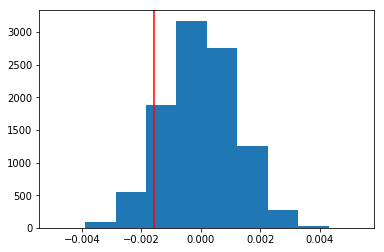

In [104]:
plt.hist(p_diffs);
plt.axvline(obs_diff,color = 'red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [105]:
(p_diffs > obs_diff).mean()

0.9012

 - This value is called p_value in scientific studies.
 - since the p_value is large (.90) we fail to reject the null hypothesis we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 



>**Since the column that we are trying to predict is categorical then we will use (logistic) regression.**

 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`. 

In [111]:
df2['intercept'] = 1
ab_page = pd.get_dummies(df2['group'])
new_df2 = df2.join(ab_page)

In [112]:
new_df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Using **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [113]:
import statsmodels.api as sm

In [114]:
log_model = sm.Logit(new_df2['converted'],new_df2[['intercept','treatment']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [115]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-04 20:08 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
treatment    -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

- In part II the alternative hypothesis stated that the conversion rate in new page is higher than the conversion rate of the old page. In part III the null and alternative hypotheses is different from part II as the alternative hypothisis states that there is statistically significant relationship between the predictor variable(treatment) and the response variable(conversion) that relationship can be positive or negative
- The hypothesis in part II was one_sided and in part III was two_sided
- We can see the p value is 0.1899 > 0.05 so we can say that there is not a statistically significant relationship between group type and conversion rate 

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- We can try to add more features to our model to see how they change it and know what are the best features we can add
- But the more we add features to our model the more it gets complecated

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [116]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [117]:
df_merged = countries.set_index('user_id').join(new_df2.set_index('user_id'), how='inner')

In [118]:
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [119]:
# Create the necessary dummy variables
country_dums = pd.get_dummies(df_merged['country'])

In [120]:
country_dums.head()

,CA,UK,US
user_id,,,
834778,0,1,0
928468,0,0,1
822059,0,1,0
711597,0,1,0
710616,0,1,0


In [121]:
final_df = df_merged.join(country_dums)
final_df.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [122]:
log_model2 = sm.Logit(final_df['converted'],final_df[['intercept','treatment','CA','UK']])
results2 = log_model2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-04 20:08 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
treatment    -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

- By looking at the p_values in the summary it seems that the p values of all the predictors are greater than 0.05 which means that we fail to reject the null hypothesis
- We dont have a clear evidence that the new page is different from old page neither the CA or UK are different from US in predicting the conversion rate

**h. Fitting the model and obtain the results**<br> 
Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


In [123]:
final_df['UK_treatment'] = final_df['UK'] * final_df['treatment']
final_df['CA_treatment'] = final_df['CA'] * final_df['treatment']

final_df.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US,UK_treatment,CA_treatment
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,1,0


In [124]:
# Fit your model, and summarize the results
log_model3 = sm.Logit(final_df['converted'],final_df[['intercept','treatment','UK','CA','CA_treatment','UK_treatment']])
results3 = log_model3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-04 20:08 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
treatment        -0.0206   0.0137   -1.5052 0.1323 -0.0473  0.0062
UK               -0.0057   0.0188   -0.3057 0.7598 -0.0426  0.0311
CA               -0.0175   0.0377   -0.4652 0.6418 -0.0914  0.0563
CA_treatment     -0.0469   0.0538   -0.8718 0.3833 -0.1523  0.0585
UK_treatment      0.0314   0.0266    1.1807 0.2377 -0.0207  0.0835
==================================================================

"""

- By looking at the p_values in the summary it seems that the p values of all the predictors are greater than 0.05 which means that we fail to reject the null hypothesis
- The influence of landing page in UK is not different to influence of landing page on other country
- The same thing for CA influence of landing page is not different to influence of landing page on other country

## Conclusions
- We dont have a clear evidence that the new page is different from old page neither the CA or UK are different from US in predicting the conversion rate

- We conclude that the new page isn't performing better than the old page and its better to stop investing in the new page 